<a href="https://colab.research.google.com/github/12dylan3/LSTockMarket-Predictions/blob/main/HybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from functools import reduce
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Preprocess

In [ ]:
def get_data(url):
    """
    read the stock data and split into train and test
    :param url: url to raw csv from github.
    :return: Tuple of train and test opening prices
    """
    # # Done TODO: load training data from training file.

    sequence_len = 50

    test_ratio = 0.2
    
    data = pd.read_csv(url)

    #use this line if using only opening price
    data = data.drop(['Date', 'High', 'Low', 'Close','Adj Close', 'Volume'], axis=1)

    #use this line instead of previous if using all stock metrics
    #data = data.drop(['Date','Adj Close'], axis=1)


    num_data_points = data.shape[0]
    split_index = math.floor(num_data_points*(1-test_ratio))

    train_data = data[:split_index]
    test_data = data[split_index:]

    #Normalize data
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    train_sequences = []
    train_labels = []
    for i in range(sequence_len, train_data.shape[0]):
      train_sequences.append(train_data[i-sequence_len:i])
      train_labels.append(train_data[i, 0])
    
    test_sequences = []
    test_labels = []
    for i in range(sequence_len, test_data.shape[0]):
      test_sequences.append(test_data[i-sequence_len:i])
      test_labels.append(test_data[i, 0])

                     
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    return (train_sequences, train_labels, test_sequences, test_labels, scaler)

Model Class

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        """
        The Model class predicts the next words in a sequence.

        :param vocab_size: The number of unique words in the data
        """

        super(Model, self).__init__()

        self.initial_state = None

        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

        self.batch_size = 50

        self.num_feats = 1


        self.lstm1 = tf.keras.layers.LSTM(96, activation='relu', input_shape = (50,self.num_feats))
        self.d1 = tf.keras.layers.Dense(50, activation='relu')
        self.d2 = tf.keras.layers.Dense(20, activation='relu')
        
        self.dropout1 = tf.keras.layers.Dropout(.10)
        self.dropout2 = tf.keras.layers.Dropout(.10)

        self.final_dense = tf.keras.layers.Dense(1)


    def call(self, inputs):
        """
        :param train_sequences: stock data for 60 day period of shape (batch_size, 60, 5)
        :return: the scaled predicted opening price for the next (61st) day  
        """

        lstm1_out = self.lstm1(inputs)
        lstm1_out = self.dropout1(lstm1_out)

        dense_out = self.d2(self.d1(lstm1_out))
        final_out = self.final_dense(dense_out)

        final_out = tf.convert_to_tensor(final_out)

        return final_out

    def loss(self, predictions, labels):
        """
        Calculates average cross entropy sequence to sequence loss of the prediction
        
        NOTE: You have to use np.reduce_mean and not np.reduce_sum when calculating your loss

        :param predictions: a matrix of shape (batch_size, 1) as a tensor
        :param labels: matrix of shape (batch_size, 1) containing the labels
        :return: the loss of the model as a tensor of size 1
        """

        loss = tf.keras.losses.mean_squared_error(labels, predictions)
        print("Loss: ", loss)
        loss = tf.reduce_mean(loss)

        return loss

Train and Results

In [ ]:
def train(model, train_sequences, train_labels):
    """
    Runs through one epoch.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_inputs,)
    :param train_labels: train labels (all labels for training) of shape (num_labels,)
    :return: None
    """
    print("In Train")

    i = 0

    while i < len(train_sequences)-model.batch_size:
        batch_inputs = train_sequences[i:i+model.batch_size]
        batch_labels = train_labels[i:i+model.batch_size]


        with tf.GradientTape() as tape:
            call_return = model.call(batch_inputs)
            loss = model.loss(call_return, batch_labels)

        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        i += model.batch_size

    pass


def test(model, test_sequences, test_labels):
    """
    Runs through all training examples.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_inputs,)
    :param train_labels: train labels (all labels for training) of shape (num_labels,)
    :return: None
    """
    print("In Test")

    loss_list = []
    predictions_list = []

    i = 0
    count = 0
    while i < len(test_sequences)-model.batch_size:
        batch_inputs = test_sequences[i:i+model.batch_size]
        batch_labels = test_labels[i:i+model.batch_size]

        call_return = model.call(batch_inputs)

        predictions_list.extend(call_return.numpy().squeeze().tolist())
        loss = model.loss(call_return, batch_labels)
        loss_list.append(loss)

        i += model.batch_size
        count += 1

    print("TEST LOSS = ", sum(loss_list)/len(loss_list))
    return predictions_list


def plot(model, test_sequences, test_labels, scale_array):
    """
    Runs through one epoch - all testing examples and plots result


    :param model: the trained model to use for prediction
    :param test_inputs: train inputs (all inputs for testing) of shape (num_inputs,)
    :param test_labels: train labels (all labels for testing) of shape (num_labels,)
    :returns: perplexity of the test set
    """
    predictions = model.call(test_sequences)
    predictions = np.squeeze(predictions, 1)

    l = model.loss(predictions, test_labels)
    print("TEST LOSS: ", l)
    
    #Undo our scaling
    scale = 1/scale_array[0]
    predictions = predictions*scale
    test_labels = test_labels*scale

    #Calculate Mean Percent Error
    errors = np.subtract(test_labels, predictions)
    errors = np.absolute(errors)
    errors = np.divide(errors, test_labels)
    error = np.mean(errors)
    error = error*100
    print("Mean absolute percentage error = " + str(error))
    
    # Plotting code adapted from Aarya Tadvalkar
    # https://kgptalkie.com/google-stock-price-prediction-using-rnn-lstm/
    plt.figure(figsize=(14,5))
    plt.plot(test_labels, color = 'red', label = 'Real Stock Price')
    plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    pass  

In [ ]:
def main():
    # ORIGINAL BASELINE
    apple_raw_url = url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/AAPL.csv'
    [train_sequences, train_labels, test_sequences, test_labels, scaler] = get_data(url)
    print(train_sequences[0])
    print(train_sequences[1])
    print("lab ", train_labels)
    print(np.shape(train_sequences))
    print(np.shape(train_labels))
    print(np.shape(test_sequences))
    print(np.shape(test_labels))
    model = Model()

    for i in range(10):
      print("EPOCH : ", i+1)
      train(model, train_sequences, train_labels)
      
    plot(model, test_sequences, test_labels, scaler.scale_)


    #USING APPLE AND SP500
    #Must change "num_feats" to 2 in model constructor!

    # apple_raw_url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/AAPL.csv'
    # [train_sequences, train_labels, test_sequences, test_labels, scaler] = get_data(apple_raw_url)

    # sp_raw_url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/^OEX.csv'
    # [train_sequencessp, _, test_sequencessp, _, _] = get_data(sp_raw_url)

    # # print(train_sequences.shape)
    # # print(train_sequencesMSFT.shape)
    # # print(np.dstack((train_sequences, train_sequencesMSFT)).shape)

    # train_sequences = np.dstack((train_sequences, train_sequencessp))

    # test_sequences = np.dstack((test_sequences, test_sequencessp[:-1]))

    
    # model = Model()

    # for i in range(10):
    #   print("EPOCH : ", i)
    #   train(model, train_sequences, train_labels)
    
    
    # plot(model, test_sequences, test_labels, scaler.scale_)


    #TO USE ALL APPL DATA
    #Change preprocessing code to only drop 'Date' and 'Avg Close'
    #Change 'num_feats' to 5 in model constructor





[[0.16756146]
 [0.15790762]
 [0.1474065 ]
 [0.11484414]
 [0.13477097]
 [0.11163432]
 [0.123667  ]
 [0.13018434]
 [0.11664455]
 [0.10328393]
 [0.09854255]
 [0.11163432]
 [0.11690523]
 [0.11570769]
 [0.1014265 ]
 [0.10784611]
 [0.10674631]
 [0.10229819]
 [0.09965054]
 [0.09984601]
 [0.13511311]
 [0.13027396]
 [0.12138593]
 [0.1091903 ]
 [0.11506406]
 [0.10959766]
 [0.11452638]
 [0.10837564]
 [0.09345089]
 [0.08988262]
 [0.08690091]
 [0.09966681]
 [0.09006183]
 [0.09498245]
 [0.09844479]
 [0.05868074]
 [0.05191083]
 [0.04061949]
 [0.05745873]
 [0.05623671]
 [0.05622044]
 [0.05795568]
 [0.05371938]
 [0.04568675]
 [0.05580494]
 [0.06132841]
 [0.07008613]
 [0.07212279]
 [0.07457495]
 [0.0645545 ]
 [0.06236304]
 [0.06589055]
 [0.05957687]
 [0.05679883]
 [0.04727536]
 [0.04992303]
 [0.05367052]
 [0.04549938]
 [0.04925501]
 [0.04568675]
 [0.040758  ]
 [0.03244833]
 [0.02729962]
 [0.03791477]
 [0.02975992]
 [0.03407768]
 [0.03403694]
 [0.03880277]
 [0.03297786]
 [0.03654615]
 [0.04070095]
 [0.04

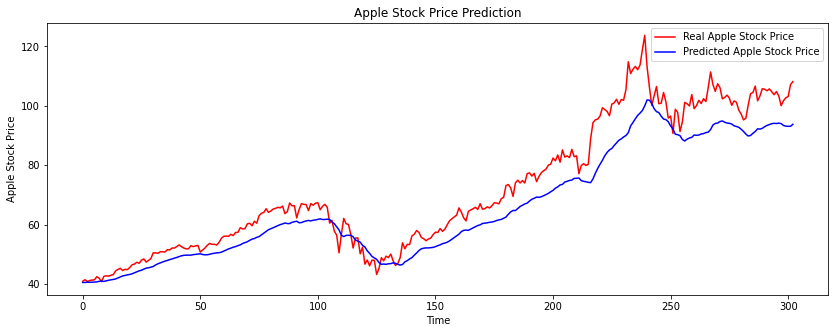

In [ ]:
main()

